In [90]:
# Utility functions
import pandas as pd
import numpy as np
from warnings import filterwarnings
import string

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# NLP
import nltk
from textblob import TextBlob

# Feature extration 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


# Statistics
from scipy import stats

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Set a random seed
np.random.seed(42)

# magic line
%matplotlib inline
# Set theme
plt.style.use('ggplot')
#ignore warnings
filterwarnings('ignore')

# ================= Uncomment if stopwords throws and error ======================== # 

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
#nltk.download('words')

### This note book will contain the visualizations necessary to motivate intuition on the corpus
- tokinasation 
- stopword creation and removal
- Lexicon normalization

In [2]:
# Load dataframe 1
PATH = '../../src/data/dataframe1.csv'

df = pd.read_csv(PATH)
df.head()

,text,target
0,Bill Changing Credit Card Rules Is Sent to Oba...,0
1,"In Hollywood, the Easy-Money Generation Toughe...",0
2,1700 runners still unaccounted for in UK's Lak...,0
3,Yankees Pitchers Trade Fielding Drills for Put...,0
4,Large earthquake rattles Indonesia; Seventh in...,0


### Split the data into training and test sets

In [3]:
X = df.drop(columns=['target'])
y = df[['target']]
X.shape, y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25600, 1), (6400, 1), (25600, 1), (6400, 1))

Text(0, 0.5, 'Document Count')

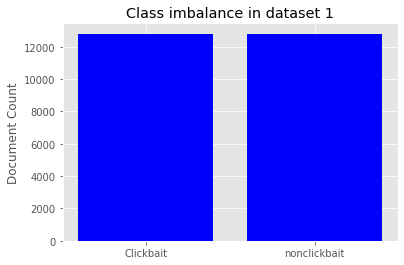

In [4]:
# Visualize the classes
plt.bar(x=['Clickbait', 'nonclickbait'], height=y_train.groupby(['target']).target.count(), color='b');
plt.title("Class imbalance in dataset 1")
plt.ylabel("Document Count")

### Visualize the class difference

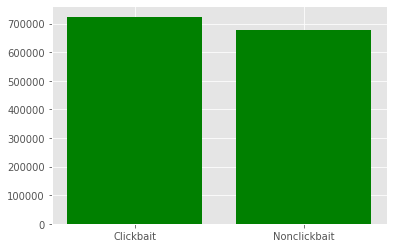

In [5]:
# Create a corpus of clickbait and nonclickbait

# join all of the messages from each class into their respective corpus
df = pd.concat([X_train, y_train], axis=1)
click = df[df.target == 1]
non = df[df.target == 0]

# Create large strings of each
click_corpus = " ".join(click.text.to_list())
non_corpus = " ".join(non.text.to_list())

plt.bar(x=['Clickbait', 'Nonclickbait'], height=[len(click_corpus), len(non_corpus)], color = 'g');

click bait corpus just seems a little bit longer than the non-clickbait corpus. Let's see of the overlapping histograms of each titles length reveals anything

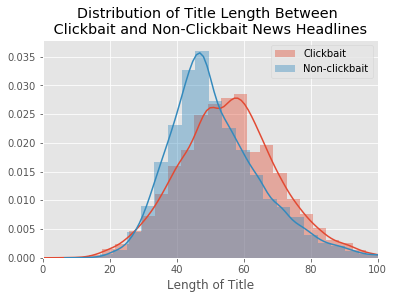

In [6]:
def get_len(string):
    return len(string)

click_len = click.text.apply(get_len)
non_len = non.text.apply(get_len)

fig, ax = plt.subplots()
for a, b in zip([click_len, non_len], ['Clickbait', 'Non-clickbait']):
    sns.distplot(a, bins=30, ax=ax, kde=True, label=b)
    plt.legend()
ax.set_xlim([0, 100])
ax.set_xlabel("Length of Title")
ax.set_title("Distribution of Title Length Between \n Clickbait and Non-Clickbait News Headlines ");

It seems that clickbait titles are slightly longer on average. I will conduct a students ttest between the two groups to see if there is significance 

In [7]:
# test for normality:
stats.normaltest(non_len), stats.normaltest(click_len)

(NormaltestResult(statistic=1866.1603570633722, pvalue=0.0),
 NormaltestResult(statistic=85.52377864217378, pvalue=2.683783213192833e-19))

Despite looking very normal, the distributions are not normal. 

In [8]:
significance = stats.mannwhitneyu(click_len, non_len)
mean_dif = int(round((click_len.mean()-non_len.mean()), 0))
print(f"Clickbait titles are on Average {mean_dif} words longer than non clickbait titles with a p value of {significance[1]}")

Clickbait titles are on Average 4 words longer than non clickbait titles with a p value of 2.0717424030770497e-138


Next, let's look at the bag of words represented by each class. To do that, first, I will tokenise each of the bag of words and then create a frequency dictionary of each class and plot the results.

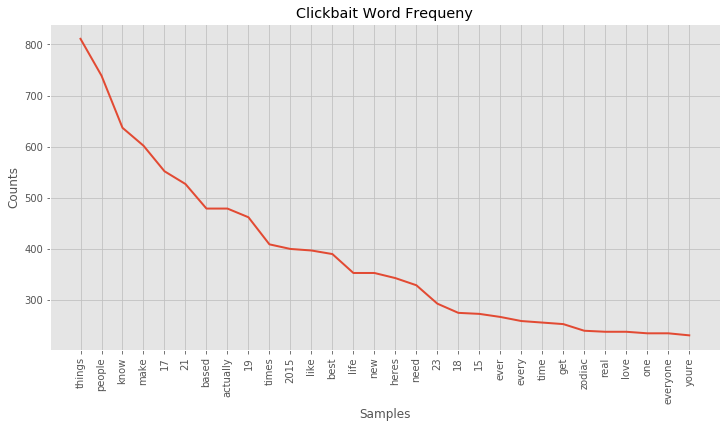

In [9]:
# Tokenizer 
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
click_tokenized = tokenizer.tokenize(click_corpus)
non_tokenized = tokenizer.tokenize(non_corpus)

# Lower case and remove stopwords
stop_words=set(stopwords.words("english"))

fil_click = [word.lower() for word in click_tokenized if word.lower() not in stop_words]
fil_non = [word.lower() for word in non_tokenized if word.lower() not in stop_words]

# Freq Dict
click_dict = FreqDist(fil_click)
non_dict = FreqDist(fil_non)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

click_dict.plot(30, title="Clickbait Word Frequeny")

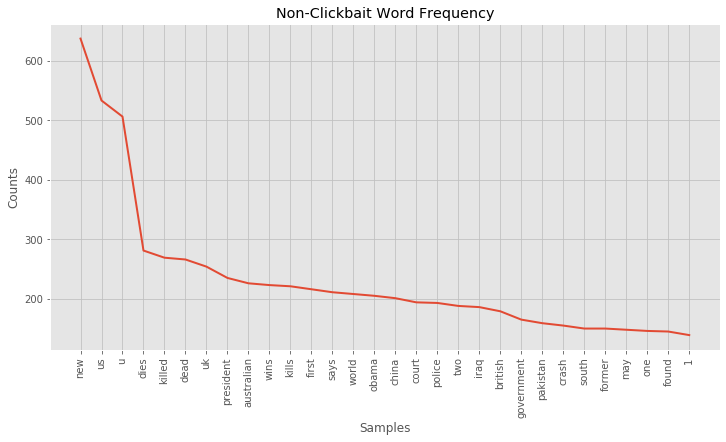

In [10]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

non_dict.plot(30, title="Non-Clickbait Word Frequency");

The composition of the words are very different. I really think a naive bayes would work for this right out of the gate. However, i have more questions about the corpus.

As an aside, I should look into removing all proper nouns from the corpus in order to increase the generalizability of the model. Obama, Trump place names too. These are all things that are relevant at the time of making the model but in the coming years will be less and less important.

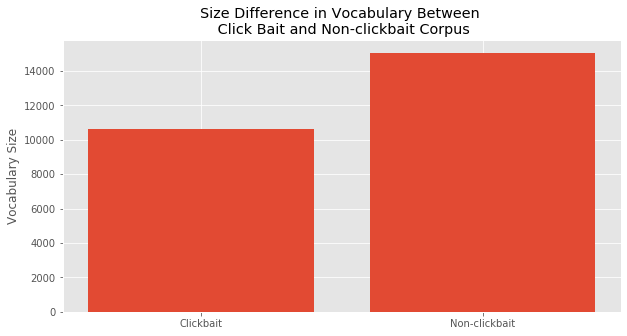

In [11]:
# Vocabulary check
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x=["Clickbait", "Non-clickbait"], height=[len(click_dict), len(non_dict)])
ax.set_ylabel("Vocabulary Size")
plt.title("Size Difference in Vocabulary Between \n Click Bait and Non-clickbait Corpus");

## Considering the difference in Vocabulary Sizes, I am interested in Visualizing those differences using word clouds

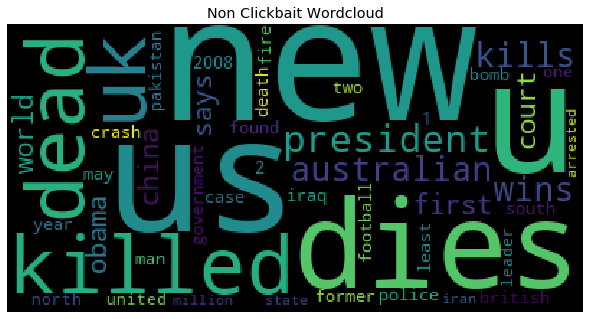

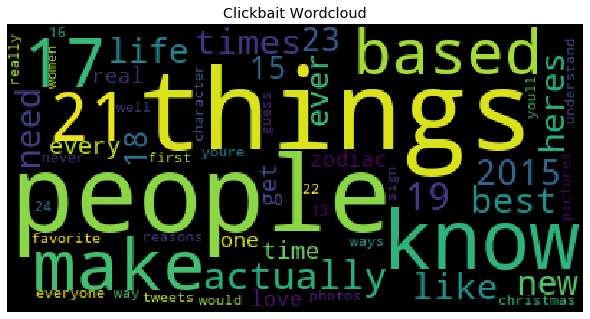

In [12]:
wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(non_dict)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Non Clickbait Wordcloud")
plt.tight_layout(pad = 0) 
  
plt.show() 

wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(click_dict)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Clickbait Wordcloud")
plt.tight_layout(pad = 0) 
  
plt.show() 

So it would seem that there are upwars of 4000 more unique words in the non-clickbait corpus. How many different words are there between the two corpus's?

In [13]:
# Using python sets
non_set = set(non_dict.keys())
click_set = set(click_dict.keys())

diff = non_set.difference(click_set)
overlap = non_set.intersection(click_set)

# Generate word clouds of each

def countX(lst, x): 
    return lst.count(x) 

non_diff = {}
for word in diff:
    non_diff[word] = countX(non_tokenized, word)

difference_frequency = sorted(non_diff.items(), reverse=True, key = (lambda x: x[1]))

## Visualize the Differences Between The Classes

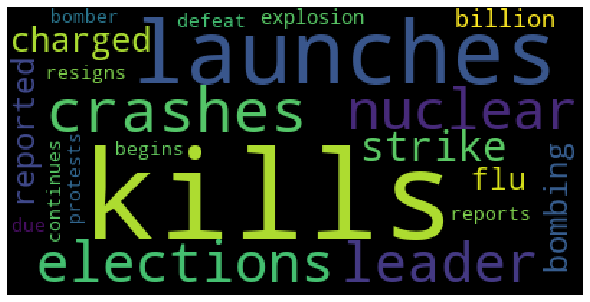

In [14]:
wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(dict(difference_frequency))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Visualize the Intersection Between the Classes

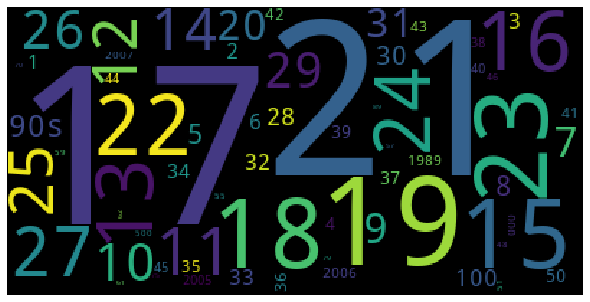

In [15]:
# Visualize the intersection between the two corpus

click_diff = {}
for word in overlap:
    click_diff[word] = countX(click_tokenized, word)

difference_frequency = sorted(click_diff.items(), reverse=True, key = (lambda x: x[1]))
wordcloud  = WordCloud(min_font_size=5).generate_from_frequencies(dict(difference_frequency))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Wow. Every overlapping string is actually a number. This begs the question, what proportion of each of the classes are numerical? If the overlapping words 

# I think we have seen enough to run a simple Naive Bayes Classifier.

- tf-idf into a sparse matrix
    - There are A LOT of features to play with in the Vectorizer. All should be gridsearched
    - vectorizer is producing a matrix of 1,1 but I want 
- run model

In [17]:
tfidf_ = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1))

In [18]:
X_train_tfidf = tfidf_.fit_transform(X_train.text)
X_test_tfidf = tfidf_.transform(X_test.text)

In [168]:
clf = BernoulliNB(alpha=0.1) # alpha 0.36 was choosen arbitralily
clf.fit(X_train_tfidf, y_train)
y_hat = clf.predict(X_test_tfidf)

accuracy_score(y_test, y_hat)

0.9628125

In [20]:
f1_score(y_test, y_hat)

0.9644575508303586

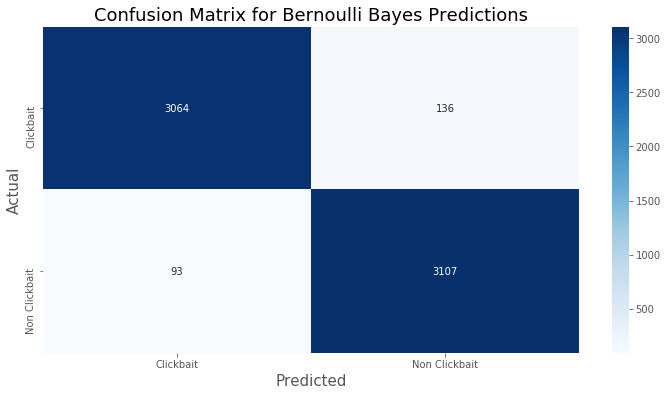

In [27]:

def plot_cmatrix(actual, predictions, model = None):
    '''Takes in arrays of actual binary values and model predictions and generates and plots a confusion matrix'''
    cmatrix = confusion_matrix(actual, predictions)

    fig, ax = plt.subplots(figsize = (12,6))
    sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xticklabels(['Clickbait', 'Non Clickbait'])
    ax.set_yticklabels(['Clickbait', 'Non Clickbait'])
    ax.set_ylabel('Actual', size=15)
    ax.set_xlabel('Predicted', size=15)
    ax.set_title(f'Confusion Matrix for {model} Predictions', size =18)
    

plot_cmatrix(y_test, y_hat, model= "Bernoulli Bayes")

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0
)

In [23]:
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [24]:
y_hat_rf = rf_classifier.predict(X_test_tfidf)

In [25]:
accuracy_score(y_test, y_hat_rf)


0.92453125

In [26]:
X_train_tfidf.shape

(25600, 20765)

### Now that I have a baseline model/I need to apply the same methods to the other two data frames.

If they perform similarly, I can start thinking about takin the model into production.

Next steps:
- train test and holdout
- testing the current model on unseeen data fromn other data sets
- 

# Dataset 2.

Creation is outlined in `datasetCreation`. The goal here is to try and salvage as much of the 3000 tweets as possible. given that the data set is not balanced, I am also gonig to use this data as a natural "holdout" data set.

In [29]:
PATH2 = '../../src/data/dataframe2.csv'
df2 = pd.read_csv(PATH2)
df2.head()

,id,post_text,name,dataset,target
0,609398299926339584,RT @BuzzFeedBooks: John Green responded on Tum...,BuzzFeed,2,0
1,609858047670923265,ISIS intercepts thousands of Syrian refugees t...,Daily Mail Online,2,0
2,607934124813205505,RT @foxnewslatino: Carlos Santana (and his wif...,Fox News,2,0
3,609361820944605185,Female scientists fire back at Nobel laureate’...,Yahoo,2,0
4,610056503626698752,RT @davidshukmanbbc: Amazing news from deep sp...,BBC News (UK),2,0


In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 5 columns):
id           2992 non-null int64
post_text    2992 non-null object
name         2992 non-null object
dataset      2992 non-null int64
target       2992 non-null int64
dtypes: int64(3), object(2)
memory usage: 117.0+ KB


In [32]:
df2.shape

(2992, 5)

Text(0, 0.5, 'Document Count')

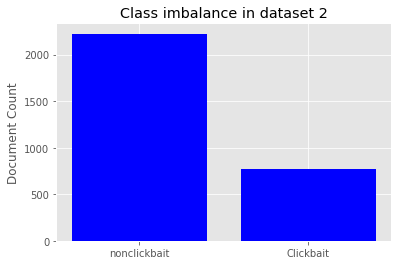

In [151]:
plt.bar(x=['nonclickbait', 'Clickbait'], height=df2.groupby(['target']).target.count(), color='b');
plt.title("Class imbalance in dataset 2")
plt.ylabel("Document Count")

In [34]:
df2.groupby(['target']).target.count()

target
0    2225
1     767
Name: target, dtype: int64

### So there is a 3:1 class imbalance. 

In addition, as these are tweets, they are pretty messy. "RT" and "@" are everywhere, I am going to have to clean them out. In addition, there are entire htmls.

Let's built a function that can clean the obvious stuff from the tweets and then generate some word clouds and look into what we see.

Note that the textblob spell checker is very slow. It should be used once over night and the series should be pickled. 

Note, that what works for news headlines doesn't necessarily work for tweets. I will first try and apply the news headline model to the tweets and get a baseline off of that

In [175]:
df2.head()

,id,post_text,name,dataset,target
0,609398299926339584,buzzfeedbooks john green responded on tumblr t...,BuzzFeed,2,0
1,609858047670923265,isis intercepts thousands of syrian refugees t...,Daily Mail Online,2,0
2,607934124813205505,foxnewslatino carlos santana and his wife rock...,Fox News,2,0
3,609361820944605185,female scientists fire back at nobel laureates...,Yahoo,2,0
4,610056503626698752,davidshukmanbbc amazing news from deep space c...,BBC News (UK),2,0


### Examine the data set

In [177]:
# Get corpus
def get_corpus(df, text='text'):
    return " ".join(df[text].to_list())

click_corpus = get_corpus(df2[df2.target==1], text='post_text')
non_corpus = get_corpus(df2[df2.target==0], text='post_text')

len(click_corpus), len(non_corpus)

(74671, 237577)

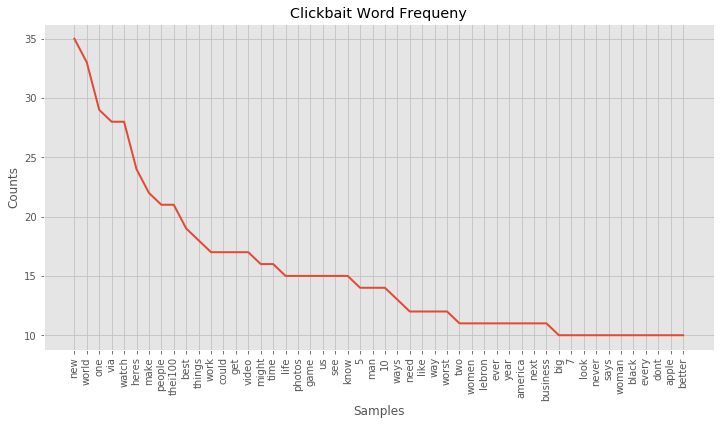

In [183]:



# Tokenizer 
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9!]+') # included ! in the analysis
click_tokenized = tokenizer.tokenize(click_corpus)
non_tokenized = tokenizer.tokenize(non_corpus)

# Lower case and remove stopwords
stop_words=set(stopwords.words("english"))

fil_click = [word.lower() for word in click_tokenized if word.lower() not in stop_words]
fil_non = [word.lower() for word in non_tokenized if word.lower() not in stop_words]

# Freq Dict
click_dict = FreqDist(fil_click)
non_dict = FreqDist(fil_non)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

click_dict.plot(50, title="Clickbait Word Frequeny")

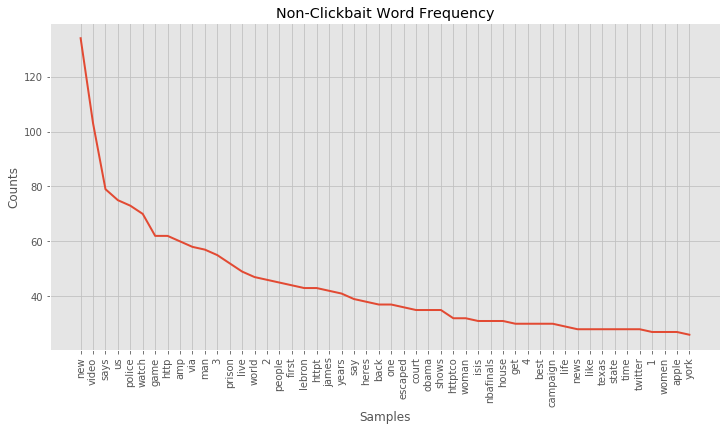

In [184]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

non_dict.plot(50, title="Non-Clickbait Word Frequency");

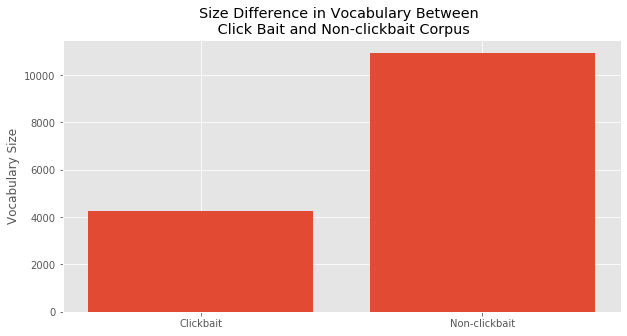

In [186]:
# Vocabulary check
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x=["Clickbait", "Non-clickbait"], height=[len(click_dict), len(non_dict)])
ax.set_ylabel("Vocabulary Size")
plt.title("Size Difference in Vocabulary Between \n Click Bait and Non-clickbait Corpus");

The difference here is amplified by the class imbalance, without the class imbalance I suspect that the difference would not be nearly as stark. We can normalize the sizes of vocabulary by the size of each class.

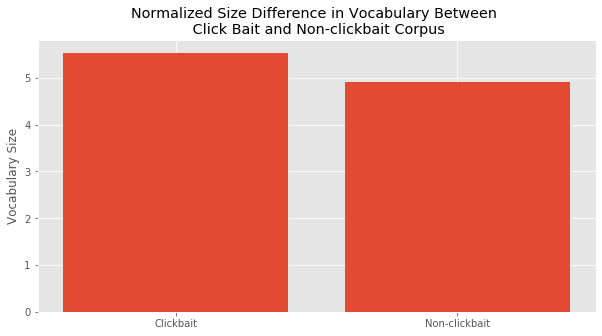

In [188]:
# Vocabulary check
fig, ax = plt.subplots(figsize=(10,5))
clicksize = df2[df2.target == 1].shape[0]
nonsize = df2[df2.target == 0].shape[0]
ax.bar(x=["Clickbait", "Non-clickbait"], height=[len(click_dict)/clicksize, len(non_dict)/nonsize])
ax.set_ylabel("Vocabulary Size")
plt.title("Normalized Size Difference in Vocabulary Between \n Click Bait and Non-clickbait Corpus");

The issue here is that after a certain point, all words are likely to be used. Therefore normalizing by the length if the length is really large actually offers up a disadvantage. I am not sure how best to represent this data.

But let's move on to the average size of the words. 

## Size of words used 

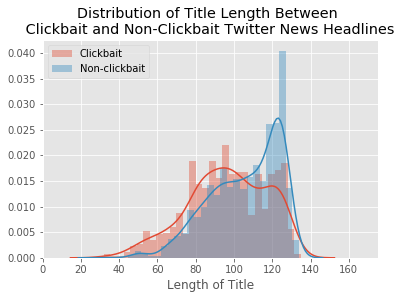

In [192]:
def get_len(string):
    return len(string)

click_len = df2[df2.target == 1].post_text.apply(get_len)
non_len = df2[df2.target == 0].post_text.apply(get_len)

fig, ax = plt.subplots()
for a, b in zip([click_len, non_len], ['Clickbait', 'Non-clickbait']):
    sns.distplot(a, bins=30, ax=ax, kde=True, label=b)
    plt.legend()
ax.set_xlim([0, 175])
ax.set_xlabel("Length of Title")
ax.set_title("Distribution of Title Length Between \n Clickbait and Non-Clickbait Twitter News Headlines ");

This really does not resembe the distributions that we saw for the first data set. These news headlines come from the same year as the previous data set. However, the sampling methodology was done differently here to the previous data set

In [107]:
words = set(nltk.corpus.words.words())

# Remove "RT" and "@"
def clean_tweets(tweet):
    tweet= tweet.replace("RT", "")
    tweet = "".join([char.lower() for char in tweet if char not in string.punctuation + "’"])
    return tweet.lstrip(" ").rstrip(" ")

def remove_non_english_words(tweet, words):
    return " ".join(word for word in nltk.wordpunct_tokenize(tweet) if word in words)

def spelling_correction(tweet):
    return " ".join([str(TextBlob(tweet).correct()) for word in tweet.split()])
    
def spelling_correction_v2(tweet):
    return " ".join([str(TextBlob(tweet).correct())])


text_with_misspld_words = df2.post_text.apply(clean_tweets)

# text_without_misspld_words = text_with_misspld_words[0:10].apply(spelling_correction_v2)

In [170]:
text_with_misspld_words

0       buzzfeedbooks john green responded on tumblr t...
1       isis intercepts thousands of syrian refugees t...
2       foxnewslatino carlos santana and his wife rock...
3       female scientists fire back at nobel laureates...
4       davidshukmanbbc amazing news from deep space c...
                              ...                        
2987    bbcsport big blow for england as buttler edges...
2988    rafael nadal reaches stuttgart semis after str...
2989    rebecca minnock told to come home by friend wh...
2990    how popes over time have handled bishops suspe...
2991    police investigating pats brandon spikes invol...
Name: post_text, Length: 2992, dtype: object

In [111]:
# Assign the cleaned text to the data frame 
df2.post_text = text_with_misspld_words

In [171]:
df2.shape

(2992, 5)

In [172]:
# try fiting the model to the text data
X_tweet = df2.post_text
y_tweet = df2.target

X_tweet_tfidf = tfidf_.transform(X_tweet)

y_hat_tweet = clf.predict(X_tweet_tfidf)
accuracy_score(y_tweet, y_hat_tweet)

0.6798128342245989

In [174]:
B_clf_tweet1 = BernoulliNB(alpha = 0.00001) # What is alpha?
tfidf_tweet_vec = TfidfVectorizer(stop_words = stop_words)

X_2_tfidf2 = tfidf_tweet_vec.fit_transform(X_tweet)

B_clf_tweet.fit(X_2_tfidf2, y_tweet)

y_hat_3_2 = B_clf_tweet.predict(X_2_tfidf2)

print(accuracy_score(y_tweet, y_hat_3_2))

confusion_matrix(y_tweet, y_hat_3_2)

0.9989973262032086


array([[2222,    3],
       [   0,  767]])

### NEWFLASH Tweets are not the same as News Headlines. 

I could go into the news articles themselves, I have access to the urls. I could set up a scraper that goes into each of the urls and pull out the headline and appends it to the dataframe. This way, I can look past the the post and analyse the url underneath it directly.

# Load dataset3

This dataset is also from twitter data but unlike dataset2, the target title is actually included in the data frame making it readily available for analysis.

In [121]:
PATH3 = '../../src/data/dataframe3.csv'
df3 = pd.read_csv(PATH3)
df3.head()

,id,post_text,title,timestamp,dataset,target
0,858462320779026433,UK’s response to modern slavery leaving victim...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,3,0
1,858421020331560960,this is good,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,3,1
2,858368123753435136,"The ""forgotten"" Trump roast: Relive his brutal...",The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,3,0
3,858323428260139008,Meet the happiest #dog in the world!,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,3,1
4,858283602626347008,Tokyo's subway is shut down amid fears over an...,Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,3,0


In [148]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19538 entries, 0 to 19537
Data columns (total 6 columns):
id           19538 non-null int64
post_text    19484 non-null object
title        19538 non-null object
timestamp    19538 non-null object
dataset      19538 non-null int64
target       19538 non-null int64
dtypes: int64(3), object(3)
memory usage: 916.0+ KB


In [150]:
df3.shape

(19538, 6)

In [152]:
df3.groupby(['target']).id.count()

target
0    14777
1     4761
Name: id, dtype: int64

In [133]:
X_3 = df3['title']
y_3 = df3['target']

X_3_tfidf = tfidf_.transform(X_3)

y_hat_3_1 = clf.predict(X_3_tfidf)

accuracy_score(y_3, y_hat_3)

0.6751458695874706

In [134]:
y_3.shape, y_hat_3.shape, X_3_tfidf.shape

((19538,), (19538,), (19538, 20765))

In [135]:
# What if we trained everything onto this data set?

In [166]:
B_clf_tweet = BernoulliNB(alpha=0)
tfidf_tweet_vec = TfidfVectorizer(stop_words = stop_words)

X_3_tfidf2 = tfidf_tweet_vec.fit_transform(X_3)

B_clf_tweet.fit(X_3_tfidf2, y_3)
y_hat_3_2 = B_clf_tweet.predict(X_3_tfidf2)

accuracy_score(y_3, y_hat_3_2)

0.9149349984645306

In [169]:
confusion_matrix(y_3, y_hat_3_2)

array([[13860,   917],
       [  745,  4016]])

# Ok so dataset three isn't performing nearly as well yet these are headlines from news agencies but does perform better if we make a new model for it.

Far more EDA is needed in order to understand the difference between these data sets. The reason for the drop in performance could be that the amazon mechanical turk method just isn't as accurate as as the method used in the chakboro paper. 

Either way more 